# Control arm

In [1]:
import numpy as np
import pandas as pd
import pyvista as pv
import deepxde as dde

from pinnDSE.geom import *
from pinnDSE.viz import *
from pinnDSE.elasticity import *
from pinnDSE.bc import *

Using TensorFlow 2 backend.

Instructions for updating:
non-resource variables are not supported in the long term


2 read mesh: 0.007012605667114258


3 coordinate transform: 2.480414390563965
2 read results: 3.475755453109741
1 total mesh and result loading: 3.6064369678497314
1 total edge processing: 0.277294397354126


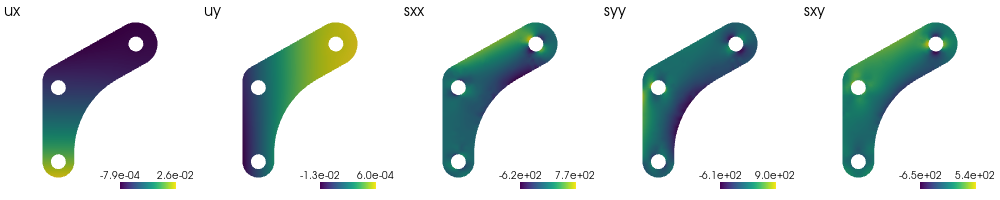

In [2]:
# load mesh and solver results
op2File = 'data/controlArm/v2.0/controlArm02.op2'
geom = MeshGeom(op2File, thickness=1.0)

# flip normals on inner edges so that they point inwards
geom.bndNormsDict[1] *= -1
geom.bndNormsDict[2] *= -1
geom.bndNormsDict[3] *= -1

plotScalarFields(geom.mesh, geom.resDf)

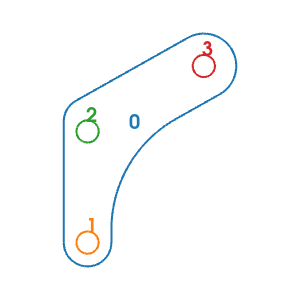

In [3]:
drawBoundaries(geom.bndDict)

### scale data-driven terms to 1 and all others to 1e-8 to track them over time

In [4]:
# train on dense point cloud
X_train = sampleDomain(geom.mesh, 2000, seed=1234)[:,:2]
y_train = geom.sampleRes(X_train).drop(columns='vonMises').values

# test on FEA nodes
X_test = np.array(geom.mesh.points[:,:2])
y_test = geom.resDf.drop(columns='vonMises').values

# supports
xBc = SupportBC(geom, bndId=3, U=0, component=0)
yBc = SupportBC(geom, bndId=3, U=0, component=1)

# traction free edges
xTr0 = TractionBC(geom, bndId=0, T=0, component=0)
yTr0 = TractionBC(geom, bndId=0, T=0, component=1)

# external loads
xTr1 = TractionBC(geom, bndId=1, T=34/geom.bndAreaDict[1], component=0)
yTr1 = TractionBC(geom, bndId=1, T=0, component=1)

xTr2 = TractionBC(geom, bndId=2, T=-34/geom.bndAreaDict[2], component=0)
yTr2 = TractionBC(geom, bndId=2, T=0, component=1)

# PointSetBC class implements data-driven terms as a BC object
ux = dde.boundary_conditions.PointSetBC(X_train, y_train[:,0].reshape(-1,1), component=0)
uy = dde.boundary_conditions.PointSetBC(X_train, y_train[:,1].reshape(-1,1), component=1)
sxx = dde.boundary_conditions.PointSetBC(X_train, y_train[:,2].reshape(-1,1), component=2)
syy = dde.boundary_conditions.PointSetBC(X_train, y_train[:,3].reshape(-1,1), component=3)
sxy = dde.boundary_conditions.PointSetBC(X_train, y_train[:,4].reshape(-1,1), component=4)

# problem setup
bndNumSamplesDir = {0:800, 1:200, 2:200, 3:200}
paramDict = {'E':2.1e5, 'nu':0.3}
bcList = [xBc,yBc,xTr0,yTr0,xTr1,yTr1,xTr2,yTr2,ux,uy,sxx,syy,sxy]
data = StrctPDE(geom, 
            elasticityEqs, 
            bcList, 
            num_domain=1000, 
            num_boundary_dir=bndNumSamplesDir, 
            num_test=500,
            paramDict=paramDict)

for bc in bcList:
    if isinstance(bc, TractionBC): 
        bc.train_n = data.train_n

# build model
net = dde.maps.FNN([2] + [64]*4  + [5], "tanh", "Glorot uniform")
outScales = np.array([1e-2, 1e-2, 1e2, 1e2, 1e2]) # [ux,uy,sxx,syy,sxy]
net.apply_output_transform(lambda x,y : y*outScales) 
model = dde.Model(data, net)

# get the unweighted loss values
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=0)
lw = losshistory.loss_train[0]**(-1)
lw[:13] *= 1e-8

# train
model.compile("adam", lr=0.001, loss_weights=lw)
losshistory, train_state = model.train(epochs=2000, display_every=100)

# test
pred = model.predict(X_train)
predDf = pd.DataFrame(pred, columns=['ux', 'uy', 'sxx', 'syy', 'sxy'])
pc = pv.PolyData(addZ(X_train))
plotScalarFields(pc, predDf, bndDict=geom.bndDict)

pred = model.predict(X_test)
predDf = pd.DataFrame(pred, columns=['ux', 'uy', 'sxx', 'syy', 'sxy'])
pc = pv.PolyData(addZ(X_test))
plotScalarFields(pc, predDf)

Compiling model...
Building feed-forward neural network...
'build' took 0.048869 s



C:\Users\ewhalen\Miniconda3\envs\pinnDSE\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
C:\Users\ewhalen\Miniconda3\envs\pinnDSE\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 2.032790 s

Initializing variables...
Training model...

Step      Train loss                                                                                                                                                                              Test loss                                                                                                                                                                               Test metric
0         [8.99e+01, 2.25e+03, 7.35e+04, 3.94e+05, 6.17e+04, 2.91e-06, 1.88e-06, 1.48e+02, 1.20e+02, 5.07e+03, 2.01e+02, 4.70e+03, 2.85e+01, 6.71e-05, 4.98e-05, 4.76e+04, 4.15e+04, 2.66e+04]    [8.96e+01, 2.31e+03, 7.75e+04, 4.14e+05, 6.53e+04, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  

Best model at step 0:
  train loss: 6.58e+05
  test loss: 5.60e+05
  test metric: []

'train' took 0.203454 s

Compiling model...
'compile' took 0.830848 

KeyboardInterrupt: 

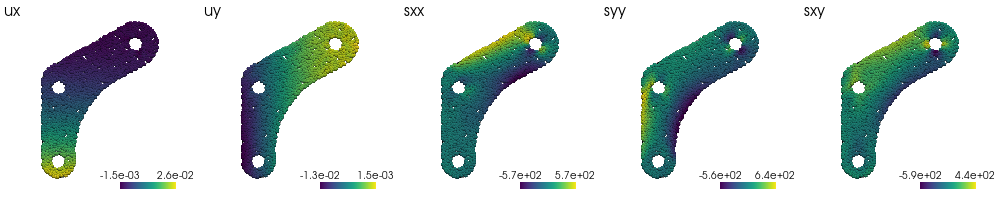

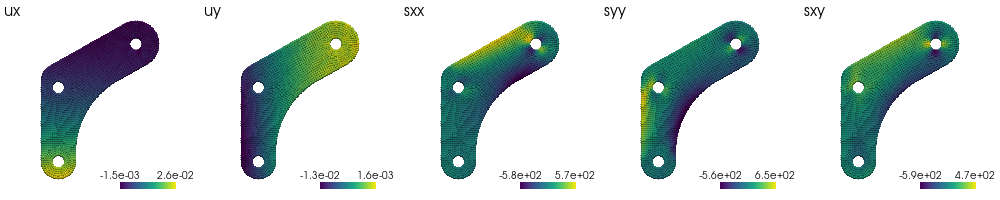

In [5]:
pred = model.predict(X_train)
predDf = pd.DataFrame(pred, columns=['ux', 'uy', 'sxx', 'syy', 'sxy'])
pc = pv.PolyData(addZ(X_train))
plotScalarFields(pc, predDf, bndDict=geom.bndDict)

pred = model.predict(X_test)
predDf = pd.DataFrame(pred, columns=['ux', 'uy', 'sxx', 'syy', 'sxy'])
pc = pv.PolyData(addZ(X_test))
plotScalarFields(pc, predDf)

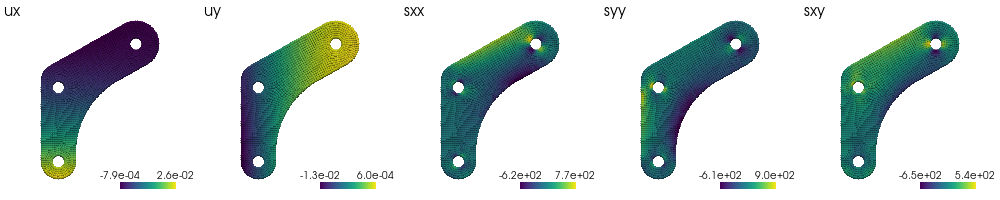

In [6]:
plotScalarFields(pc, geom.resDf)

In [7]:
bcNames = ['xBc','yBc','xTr0','yTr0','xTr1','yTr1','xTr2','yTr2','ux','uy','sxx','syy','sx']
# lines = alt.Chart(pd.DataFrame({'step':[1000,3000,4000]})).mark_rule(color='gray').encode(x='step:Q')
lossPlot(losshistory, bcNames, dropFirstStep=True).properties(width=600, height=600)

alt.Chart(...)

In [20]:
lw

array([8.07754037e-12, 4.09056573e-11, 1.17709038e-13, 4.16607904e-14,
       5.21500161e-13, 8.42841994e-03, 8.64789728e-03, 2.70539771e-11,
       9.81131010e-11, 1.84588911e-12, 1.04282749e-10, 2.17001287e-12,
       3.24844041e-10, 1.06839375e+04, 2.69095449e+04, 2.23401094e-05,
       2.37547702e-05, 3.87923210e-05], dtype=float32)

### leave data-driven terms unscaled and all others to 1e-8
Doesn't work as well since stress and displacement are in different units

Compiling model...
Building feed-forward neural network...
'build' took 0.042886 s

'compile' took 1.048223 s

Initializing variables...
Training model...

Step      Train loss                                                                                                                                                                              Test loss                                                                                                                                                                               Test metric
0         [4.48e+02, 5.36e+02, 1.81e+05, 1.57e+04, 1.53e+05, 6.76e-06, 2.39e-07, 2.57e+02, 9.41e+01, 5.01e+03, 6.61e+01, 4.96e+03, 7.87e+01, 1.09e-04, 3.95e-05, 4.74e+04, 4.19e+04, 2.72e+04]    [4.74e+02, 5.32e+02, 1.90e+05, 1.55e+04, 1.61e+05, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  

Best model at step 0:
  train loss: 4.77e+05
  test loss: 3.68e+05
  t

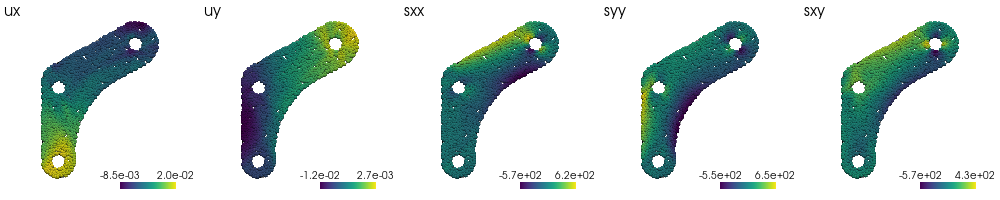

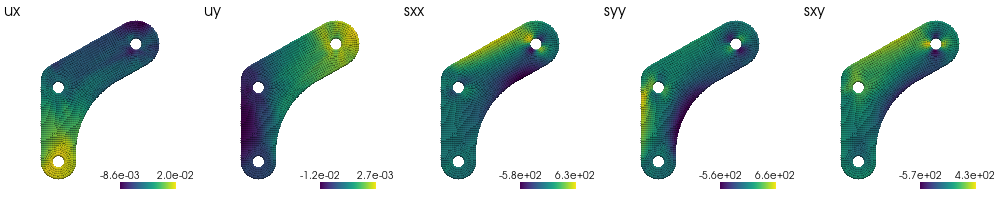

In [14]:
# train on dense point cloud
X_train = sampleDomain(geom.mesh, 2000, seed=1234)[:,:2]
y_train = geom.sampleRes(X_train).drop(columns='vonMises').values

# test on FEA nodes
X_test = np.array(geom.mesh.points[:,:2])
y_test = geom.resDf.drop(columns='vonMises').values

# supports
xBc = SupportBC(geom, bndId=3, U=0, component=0)
yBc = SupportBC(geom, bndId=3, U=0, component=1)

# traction free edges
xTr0 = TractionBC(geom, bndId=0, T=0, component=0)
yTr0 = TractionBC(geom, bndId=0, T=0, component=1)

# external loads
xTr1 = TractionBC(geom, bndId=1, T=34/geom.bndAreaDict[1], component=0)
yTr1 = TractionBC(geom, bndId=1, T=0, component=1)

xTr2 = TractionBC(geom, bndId=2, T=-34/geom.bndAreaDict[2], component=0)
yTr2 = TractionBC(geom, bndId=2, T=0, component=1)

# PointSetBC class implements data-driven terms as a BC object
ux = dde.boundary_conditions.PointSetBC(X_train, y_train[:,0].reshape(-1,1), component=0)
uy = dde.boundary_conditions.PointSetBC(X_train, y_train[:,1].reshape(-1,1), component=1)
sxx = dde.boundary_conditions.PointSetBC(X_train, y_train[:,2].reshape(-1,1), component=2)
syy = dde.boundary_conditions.PointSetBC(X_train, y_train[:,3].reshape(-1,1), component=3)
sxy = dde.boundary_conditions.PointSetBC(X_train, y_train[:,4].reshape(-1,1), component=4)

# problem setup
bndNumSamplesDir = {0:800, 1:200, 2:200, 3:200}
paramDict = {'E':2.1e5, 'nu':0.3}
bcList = [xBc,yBc,xTr0,yTr0,xTr1,yTr1,xTr2,yTr2,ux,uy,sxx,syy,sxy]
data = StrctPDE(geom, 
            elasticityEqs, 
            bcList, 
            num_domain=1000, 
            num_boundary_dir=bndNumSamplesDir, 
            num_test=500,
            paramDict=paramDict)

for bc in bcList:
    if isinstance(bc, TractionBC): 
        bc.train_n = data.train_n

# build model
net = dde.maps.FNN([2] + [64]*4  + [5], "tanh", "Glorot uniform")
outScales = np.array([1e-2, 1e-2, 1e2, 1e2, 1e2]) # [ux,uy,sxx,syy,sxy]
net.apply_output_transform(lambda x,y : y*outScales) 
model = dde.Model(data, net)

# get the unweighted loss values
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=0)
lw = losshistory.loss_train[0]**(-1)
lw[:13] *= 1e-8
lw[13:] = 1

# train
model.compile("adam", lr=0.001, loss_weights=lw)
losshistory, train_state = model.train(epochs=1000, display_every=100)

# test
pred = model.predict(X_train)
predDf = pd.DataFrame(pred, columns=['ux', 'uy', 'sxx', 'syy', 'sxy'])
pc = pv.PolyData(addZ(X_train))
plotScalarFields(pc, predDf, bndDict=geom.bndDict)

pred = model.predict(X_test)
predDf = pd.DataFrame(pred, columns=['ux', 'uy', 'sxx', 'syy', 'sxy'])
pc = pv.PolyData(addZ(X_test))
plotScalarFields(pc, predDf)

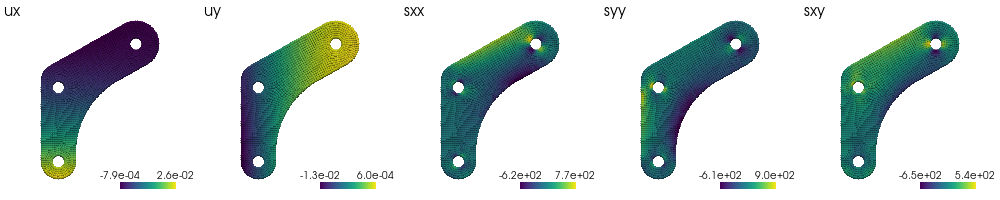

In [15]:
plotScalarFields(pc, geom.resDf)

In [17]:
bcNames = ['xBc','yBc','xTr0','yTr0','xTr1','yTr1','xTr2','yTr2','ux','uy','sxx','syy','sx']
# lines = alt.Chart(pd.DataFrame({'step':[1000,3000,4000]})).mark_rule(color='gray').encode(x='step:Q')
lossPlot(losshistory, bcNames, dropFirstStep=True).properties(width=600, height=600)

alt.Chart(...)

### verify that DIV terms increase even when trained exactly on FEA points

Compiling model...
Building feed-forward neural network...
'build' took 0.047872 s

'compile' took 1.086801 s

Initializing variables...
Training model...

0         [4.53e+02, 6.01e+01, 1.88e+05, 1.20e+06, 1.14e+02, 2.99e-07, 4.10e-06, 4.08e+01, 6.28e+01, 4.98e+03, 1.34e+02, 4.68e+03, 4.55e+01, 9.54e-05, 3.51e-05, 4.98e+04, 4.84e+04, 2.81e+04]    [4.67e+02, 5.99e+01, 1.93e+05, 1.24e+06, 1.15e+02, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  

Best model at step 0:
  train loss: 1.53e+06
  test loss: 1.43e+06
  test metric: []

'train' took 0.315125 s

Compiling model...
'compile' took 0.808944 s

Initializing variables...
Training model...

Step      Train loss                                                                                                                                                                              Test loss                                                       

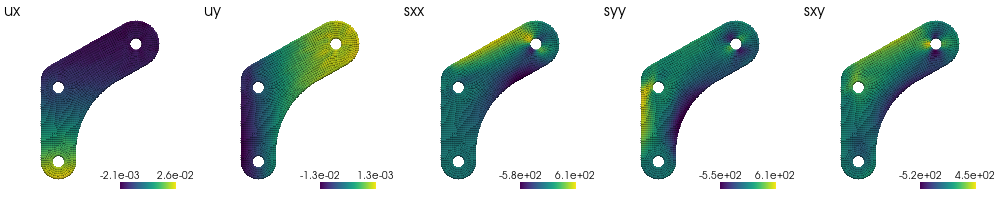

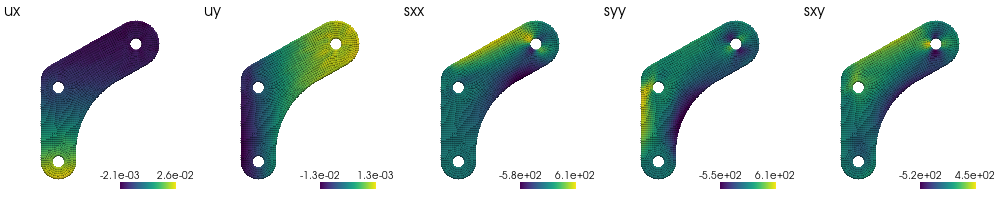

In [8]:


# test on FEA nodes
X_test = np.array(geom.mesh.points[:,:2])
y_test = geom.resDf.drop(columns='vonMises').values

# train on dense point cloud
X_train = X_test
y_train = y_test

# supports
xBc = SupportBC(geom, bndId=3, U=0, component=0)
yBc = SupportBC(geom, bndId=3, U=0, component=1)

# traction free edges
xTr0 = TractionBC(geom, bndId=0, T=0, component=0)
yTr0 = TractionBC(geom, bndId=0, T=0, component=1)

# external loads
xTr1 = TractionBC(geom, bndId=1, T=34/geom.bndAreaDict[1], component=0)
yTr1 = TractionBC(geom, bndId=1, T=0, component=1)

xTr2 = TractionBC(geom, bndId=2, T=-34/geom.bndAreaDict[2], component=0)
yTr2 = TractionBC(geom, bndId=2, T=0, component=1)

# PointSetBC class implements data-driven terms as a BC object
ux = dde.boundary_conditions.PointSetBC(X_train, y_train[:,0].reshape(-1,1), component=0)
uy = dde.boundary_conditions.PointSetBC(X_train, y_train[:,1].reshape(-1,1), component=1)
sxx = dde.boundary_conditions.PointSetBC(X_train, y_train[:,2].reshape(-1,1), component=2)
syy = dde.boundary_conditions.PointSetBC(X_train, y_train[:,3].reshape(-1,1), component=3)
sxy = dde.boundary_conditions.PointSetBC(X_train, y_train[:,4].reshape(-1,1), component=4)

# problem setup
bndNumSamplesDir = {0:800, 1:200, 2:200, 3:200}
paramDict = {'E':2.1e5, 'nu':0.3}
bcList = [xBc,yBc,xTr0,yTr0,xTr1,yTr1,xTr2,yTr2,ux,uy,sxx,syy,sxy]
data = StrctPDE(geom, 
            elasticityEqs, 
            bcList, 
            num_domain=1000, 
            num_boundary_dir=bndNumSamplesDir, 
            num_test=500,
            paramDict=paramDict)

for bc in bcList:
    if isinstance(bc, TractionBC): 
        bc.train_n = data.train_n

# build model
net = dde.maps.FNN([2] + [64]*4  + [5], "tanh", "Glorot uniform")
outScales = np.array([1e-2, 1e-2, 1e2, 1e2, 1e2]) # [ux,uy,sxx,syy,sxy]
net.apply_output_transform(lambda x,y : y*outScales) 
model = dde.Model(data, net)

# get the unweighted loss values
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=0)
lw = losshistory.loss_train[0]**(-1)
lw[:13] *= 1e-8

# train
model.compile("adam", lr=0.001, loss_weights=lw)
losshistory, train_state = model.train(epochs=1000, display_every=100)

# test
pred = model.predict(X_train)
predDf = pd.DataFrame(pred, columns=['ux', 'uy', 'sxx', 'syy', 'sxy'])
pc = pv.PolyData(addZ(X_train))
plotScalarFields(pc, predDf, bndDict=geom.bndDict)

pred = model.predict(X_test)
predDf = pd.DataFrame(pred, columns=['ux', 'uy', 'sxx', 'syy', 'sxy'])
pc = pv.PolyData(addZ(X_test))
plotScalarFields(pc, predDf)

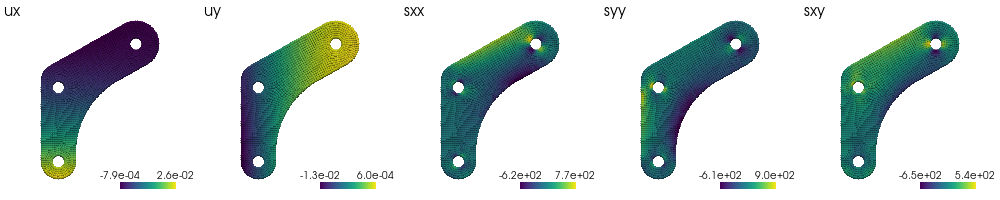

In [9]:
plotScalarFields(pc, geom.resDf)

In [10]:
bcNames = ['xBc','yBc','xTr0','yTr0','xTr1','yTr1','xTr2','yTr2','ux','uy','sxx','syy','sx']
# lines = alt.Chart(pd.DataFrame({'step':[1000,3000,4000]})).mark_rule(color='gray').encode(x='step:Q')
lossPlot(losshistory, bcNames, dropFirstStep=True).properties(width=600, height=600)

alt.Chart(...)